In [37]:
#!/usr/bin/env python
"""
Demo for STEMPO dynamic tomography test problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Silvia Gazzola"
__affiliations__ = 'MIT and Tufts University, and University of Bath'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "Apache"
__version__ = "1.0"
__email__ = "mpasha@mit.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk;"

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import astra
from venv import create
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.solvers.MMGKS import *
import requests
import numpy as np
import h5py
import pylops
from trips.utilities.helpers import *
from trips.utilities.io import *
from trips.utilities.operators import *
from trips.solvers.Hybrid_LSQR import *

In [39]:
(F_, d, Aseq, B, nx, ny, nt, savedelta, truth_) = generate_stempo1(data_set = 'simulation', data_thinning = 2, noise_level = 0.01, nt=30,new_shape=(128,128),views=5)

<Figure size 640x480 with 0 Axes>

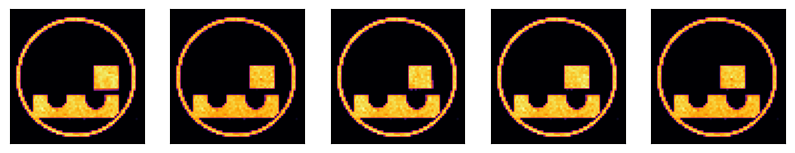

In [63]:
plt.set_cmap('inferno');
fig,ax=plt.subplots(1,t_end,figsize=(10,5))
for i in range(0,t_end):
    ax[i].imshow(truth[i].reshape(shape))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

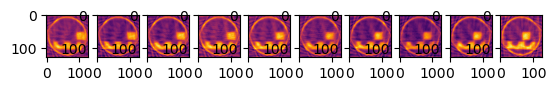

In [5]:
xs = []
for i in range(10):
    A = Aseq[i] #@np.identity(Aseq[i].shape[1])
    b = B[i]
    x = scipy.sparse.linalg.lsqr(A,b)[0] #np.linalg.lstsq(A,b)
    xs.append(x)
fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(xs[i].reshape(nx,ny))

## Views: 5; GS:1

In [53]:
from imports import *
from trips.solvers.MMGKS import *
shape = (64,64)
(F_, d, Aseq, B, nx, ny, nt, savedelta, truth_) = generate_stempo1(data_set = 'simulation', data_thinning = 2, noise_level = 0.01, nt=30,new_shape=shape,views=5)
t_end=5
t_0 = 5
truth = truth_[t_0:t_0+t_end]

A1=Aseq[1]
L = spatial_derivative_operator(nx, ny, 1)
I = sparse.identity(A1.shape[1])
I_bar = scipy.sparse.block_diag([I for i in range(t_0,t_0+t_end)]) 
A_bar = pylops.BlockDiag([Aseq[i] for i in range(t_0,t_0+t_end)])
L = gen_first_derivative_operator_2D(nx, ny)
L_bar = scipy.sparse.block_diag([L for i in range(t_end)]) #pylops.BlockDiag([L for i in range(0,t_end)])
data_vec_bar = vec(np.array([B[t] for t in  range(t_0,t_0+t_end)])).reshape(-1,1)
delta = np.mean(savedelta)# la.norm(data_vec_true_bar-data_vec_bar) #/#la.norm(data_vec_true_bar)
print(delta)

0.23005443255106608


In [54]:

n_iter = 200
n_iter_b = 20
proj_dim = 10
vs_true = None# vs 
v_primes_true= None#v_primes 
reduction = True
scale = 2
epsilon=1e-1
non_neg =   True
size=nx*ny
shape = (nx,ny)
v_max = 1

X_true = truth.flatten()
# MMGKS

from imports import *
from trips.solvers.MMGKS import *


(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)

#GS
nt=t_end
L = gen_spacetime_derivative_operator(nx, ny, nt)
(X_GS, info_GS) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, Gs_option= 'gs', prob_dims = (nx,ny, nt),delta=delta)
error_GS = info_GS['relError'][-1]
X_GS[X_GS<0]=0
X_GS_list = [X_GS[size*i:size*(i+1)] for i in range(t_end)]
print('TV iso Solution relative error:', error_GS)

# ## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2,qnorm_opt=2,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']
X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


MMGKS Solution relative error: 0.5858487912887387


running MMGKS...: 100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


TV iso Solution relative error: 0.4856432543202567


running MMGKS...: 100%|██████████| 200/200 [05:48<00:00,  1.74s/it]

Dynamic MMGKS Solution relative error: 0.4554886109967663


In [55]:
print('RRE_MMGKS',rre_all(X_mmgks,X_true,nt,nx,ny))
print('RRE_MMGKS_DYN',rre_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('RRE_GS',rre_all(X_GS,X_true,nt,nx,ny))
print('SSIM_MMGKS',ssim_all(X_mmgks,X_true,nt,nx,ny))
print('SSIM_MMGKS_DYN',ssim_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('SSIM_GS',ssim_all(X_GS,X_true,nt,nx,ny))

RRE_MMGKS 0.5850081012131321
RRE_MMGKS_DYN 0.45546085764815675
RRE_GS 0.4739627741766836
SSIM_MMGKS 0.756047573131064
SSIM_MMGKS_DYN 0.8538313252285148
SSIM_GS 0.8411709149787985


In [56]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
print('RRE_optical_flow_rec',rre_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))
print('SSIM_optical_flow_rec',ssim_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))

RRE_optical_flow_rec 0.06991324025999056
SSIM_optical_flow_rec 0.9966109522350731


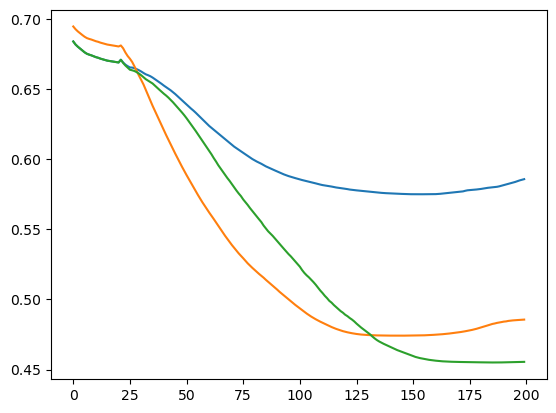

In [57]:
plt.plot(info_mmgks['relError'])
plt.plot(info_GS['relError'])
plt.plot(info_mmgks_dyn['relError'])

<Figure size 640x480 with 0 Axes>

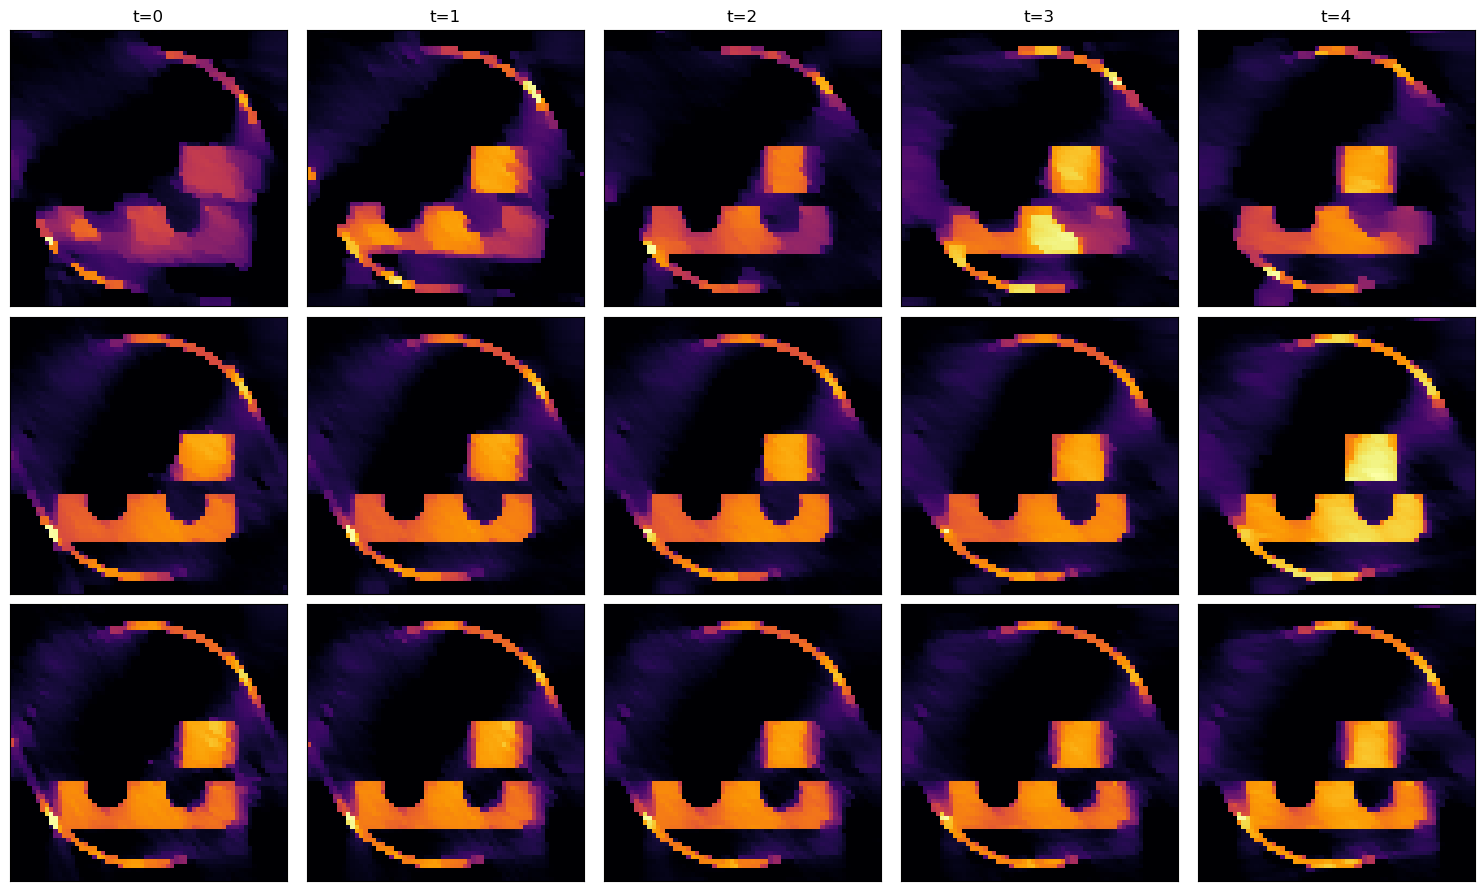

In [59]:
plt.set_cmap('inferno')
fig,ax=plt.subplots(3,t_end,figsize=(15,9),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[2,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[1,i].imshow(X_GS_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
plt.subplots_adjust(wspace=None, hspace=None)
fig.tight_layout(h_pad=1)
# fig.suptitle('Recovered Solutions to the Regularized Problem '  + '(Top Row: Recovered with MMGKS;' + 
#                 ' Middle Row: Recovered with TV-ISO;'   + 
#              ' Bottom Row: Recovered with Dynamic MMGKS)' + '\n' );

In [61]:
folder = 'example_2/views_5'
np.save(f'{folder}/X_mmgks.npy',X_mmgks)
np.save(f'{folder}/X_mmgks_dyn.npy',X_mmgks_dyn)
np.save(f'{folder}/X_GS.npy',X_GS)
np.save(f'{folder}/relError_mmgks.npy',info_mmgks['relError'])
np.save(f'{folder}/relError_mmgks_dyn.npy',info_mmgks_dyn['relError'])
np.save(f'{folder}/relError_GS.npy',info_GS['relError'])
np.save(f'{folder}/regParam_mmgks.npy',info_mmgks['regParam_history'])
np.save(f'{folder}/regParam_mmgks_dyn.npy',info_mmgks_dyn['regParam_history'])
np.save(f'{folder}/regParam_GS.npy',info_GS['regParam_history'])

## Views: 8; GS:1

In [64]:
from imports import *
from trips.solvers.MMGKS import *
shape = (64,64)
(F_, d, Aseq, B, nx, ny, nt, savedelta, truth_) = generate_stempo1(data_set = 'simulation', data_thinning = 2, noise_level = 0.01, nt=30,new_shape=shape,views=8)
t_end=5
t_0 = 5
truth = truth_[t_0:t_0+t_end]

A1=Aseq[1]
L = spatial_derivative_operator(nx, ny, 1)
I = sparse.identity(A1.shape[1])
I_bar = scipy.sparse.block_diag([I for i in range(t_0,t_0+t_end)]) 
A_bar = pylops.BlockDiag([Aseq[i] for i in range(t_0,t_0+t_end)])
L = gen_first_derivative_operator_2D(nx, ny)
L_bar = scipy.sparse.block_diag([L for i in range(t_end)]) #pylops.BlockDiag([L for i in range(0,t_end)])
data_vec_bar = vec(np.array([B[t] for t in  range(t_0,t_0+t_end)])).reshape(-1,1)
delta = np.mean(savedelta)# la.norm(data_vec_true_bar-data_vec_bar) #/#la.norm(data_vec_true_bar)
print(delta)

0.29427711041768395


In [65]:

n_iter = 200
n_iter_b = 20
proj_dim = 10
vs_true = None# vs 
v_primes_true= None#v_primes 
reduction = True
scale = 2
epsilon=1e-1
non_neg =   True
size=nx*ny
shape = (nx,ny)
v_max = 1

X_true = truth.flatten()
# MMGKS

from imports import *
from trips.solvers.MMGKS import *


(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)

#GS
nt=t_end
L = gen_spacetime_derivative_operator(nx, ny, nt)
(X_GS, info_GS) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, Gs_option= 'gs', prob_dims = (nx,ny, nt),delta=delta)
error_GS = info_GS['relError'][-1]
X_GS[X_GS<0]=0
X_GS_list = [X_GS[size*i:size*(i+1)] for i in range(t_end)]
print('TV iso Solution relative error:', error_GS)

# ## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2,qnorm_opt=2,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']
X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


MMGKS Solution relative error: 0.451090333863837


running MMGKS...: 100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


TV iso Solution relative error: 0.36565698855993517


running MMGKS...:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\okuno\anaconda3\Lib\site-packages\scipy\sparse\_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
running MMGKS...: 100%|██████████| 200/200 [05:58<00:00,  1.79s/it]


Dynamic MMGKS Solution relative error: 0.3339317247204173


In [66]:
print('RRE_MMGKS',rre_all(X_mmgks,X_true,nt,nx,ny))
print('RRE_MMGKS_DYN',rre_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('RRE_GS',rre_all(X_GS,X_true,nt,nx,ny))
print('SSIM_MMGKS',ssim_all(X_mmgks,X_true,nt,nx,ny))
print('SSIM_MMGKS_DYN',ssim_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('SSIM_GS',ssim_all(X_GS,X_true,nt,nx,ny))

RRE_MMGKS 0.4509904578322284
RRE_MMGKS_DYN 0.3339298575239759
RRE_GS 0.3599795129912772
SSIM_MMGKS 0.8646673365632737
SSIM_MMGKS_DYN 0.9246018942120362
SSIM_GS 0.912114489488722


In [67]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
print('RRE_optical_flow_rec',rre_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))
print('SSIM_optical_flow_rec',ssim_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))

RRE_optical_flow_rec 0.11844101147993837
SSIM_optical_flow_rec 0.9904491351351425


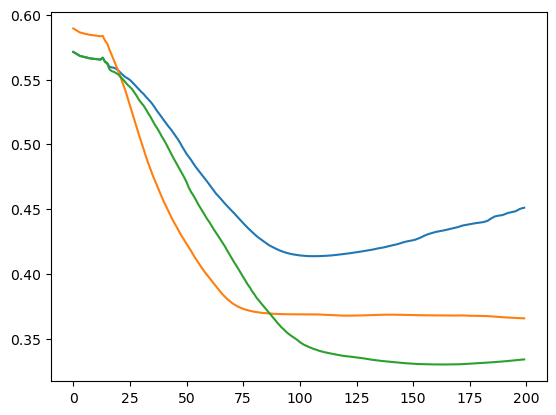

In [68]:
plt.plot(info_mmgks['relError'])
plt.plot(info_GS['relError'])
plt.plot(info_mmgks_dyn['relError'])

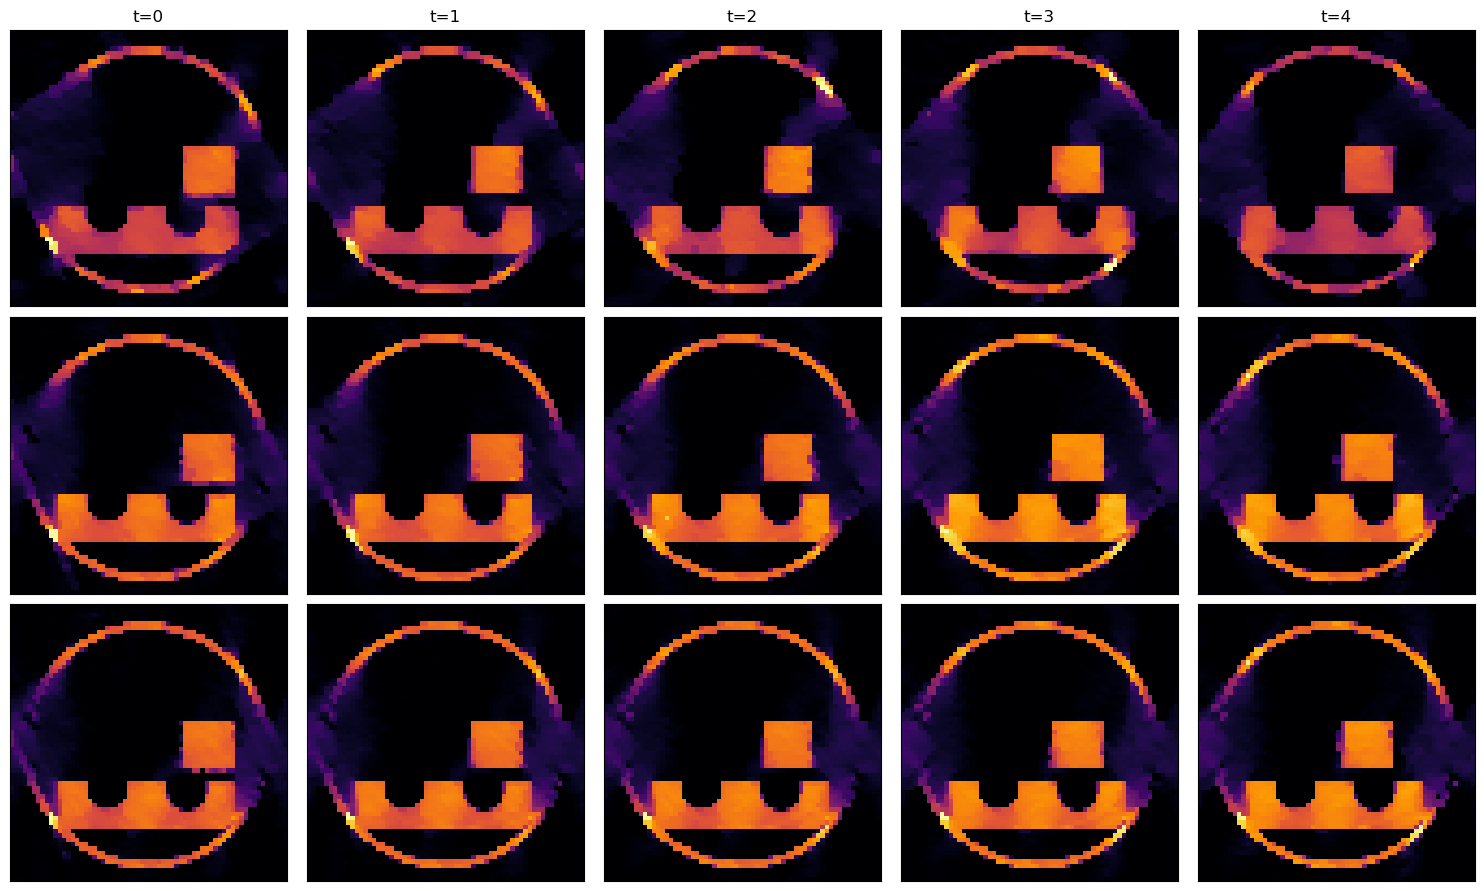

In [69]:
fig,ax=plt.subplots(3,t_end,figsize=(15,9),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[2,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[1,i].imshow(X_GS_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
plt.subplots_adjust(wspace=None, hspace=None)
fig.tight_layout(h_pad=1)
# fig.suptitle('Recovered Solutions to the Regularized Problem '  + '(Top Row: Recovered with MMGKS;' + 
#                 ' Middle Row: Recovered with TV-ISO;'   + 
#              ' Bottom Row: Recovered with Dynamic MMGKS)' + '\n' );

In [70]:
folder = 'example_2/views_8'
np.save(f'{folder}/X_mmgks.npy',X_mmgks)
np.save(f'{folder}/X_mmgks_dyn.npy',X_mmgks_dyn)
np.save(f'{folder}/X_GS.npy',X_GS)
np.save(f'{folder}/relError_mmgks.npy',info_mmgks['relError'])
np.save(f'{folder}/relError_mmgks_dyn.npy',info_mmgks_dyn['relError'])
np.save(f'{folder}/relError_GS.npy',info_GS['relError'])
np.save(f'{folder}/regParam_mmgks.npy',info_mmgks['regParam_history'])
np.save(f'{folder}/regParam_mmgks_dyn.npy',info_mmgks_dyn['regParam_history'])
np.save(f'{folder}/regParam_GS.npy',info_GS['regParam_history'])

## Views: 11; GS:1

In [71]:
from imports import *
from trips.solvers.MMGKS import *
shape = (64,64)
(F_, d, Aseq, B, nx, ny, nt, savedelta, truth_) = generate_stempo1(data_set = 'simulation', data_thinning = 2, noise_level = 0.01, nt=30,new_shape=shape,views=11)
t_end=5
t_0 = 5
truth = truth_[t_0:t_0+t_end]

A1=Aseq[1]
L = spatial_derivative_operator(nx, ny, 1)
I = sparse.identity(A1.shape[1])
I_bar = scipy.sparse.block_diag([I for i in range(t_0,t_0+t_end)]) 
A_bar = pylops.BlockDiag([Aseq[i] for i in range(t_0,t_0+t_end)])
L = gen_first_derivative_operator_2D(nx, ny)
L_bar = scipy.sparse.block_diag([L for i in range(t_end)]) #pylops.BlockDiag([L for i in range(0,t_end)])
data_vec_bar = vec(np.array([B[t] for t in  range(t_0,t_0+t_end)])).reshape(-1,1)
delta = np.mean(savedelta)# la.norm(data_vec_true_bar-data_vec_bar) #/#la.norm(data_vec_true_bar)
print(delta)

0.34708636093139655


In [72]:

n_iter = 200
n_iter_b = 20
proj_dim = 10
vs_true = None# vs 
v_primes_true= None#v_primes 
reduction = True
scale = 2
epsilon=1e-1
non_neg =   True
size=nx*ny
shape = (nx,ny)
v_max = 1

X_true = truth.flatten()
# MMGKS

from imports import *
from trips.solvers.MMGKS import *


(X_mmgks, info_mmgks) = MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = 'dp', x_true = X_true.reshape((-1,1)), epsilon=epsilon,opt='nonscaled',delta=delta,non_neg=non_neg)
error_mmgks = info_mmgks['relError'][-1]

X_mmgks[X_mmgks<0]=0
X_mmgks_list = [X_mmgks[size*i:size*(i+1)] for i in range(t_end)]

print('MMGKS Solution relative error:', error_mmgks)

#GS
nt=t_end
L = gen_spacetime_derivative_operator(nx, ny, nt)
(X_GS, info_GS) = MMGKS(A_bar, data_vec_bar, L, pnorm=2, qnorm= 1, projection_dim=proj_dim, n_iter = n_iter, 
                                regparam = 'dp', x_true = X_true.reshape((-1,1)) , epsilon = epsilon, Gs_option= 'gs', prob_dims = (nx,ny, nt),delta=delta)
error_GS = info_GS['relError'][-1]
X_GS[X_GS<0]=0
X_GS_list = [X_GS[size*i:size*(i+1)] for i in range(t_end)]
print('TV iso Solution relative error:', error_GS)

# ## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2,qnorm_opt=2,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']
X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


MMGKS Solution relative error: 0.22537552139277003


running MMGKS...: 100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


TV iso Solution relative error: 0.05950804302233154


running MMGKS...: 100%|██████████| 200/200 [06:06<00:00,  1.83s/it]

Dynamic MMGKS Solution relative error: 0.05654817569320401


In [73]:
print('RRE_MMGKS',rre_all(X_mmgks,X_true,nt,nx,ny))
print('RRE_MMGKS_DYN',rre_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('RRE_GS',rre_all(X_GS,X_true,nt,nx,ny))
print('SSIM_MMGKS',ssim_all(X_mmgks,X_true,nt,nx,ny))
print('SSIM_MMGKS_DYN',ssim_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('SSIM_GS',ssim_all(X_GS,X_true,nt,nx,ny))

RRE_MMGKS 0.2241092375909243
RRE_MMGKS_DYN 0.05644204217491633
RRE_GS 0.05662631694675242
SSIM_MMGKS 0.9657698747146035
SSIM_MMGKS_DYN 0.9978653051045269
SSIM_GS 0.9978266560675829


In [74]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
print('RRE_optical_flow_rec',rre_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))
print('SSIM_optical_flow_rec',ssim_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))

RRE_optical_flow_rec 0.13203683072425892
SSIM_optical_flow_rec 0.9885199387239203


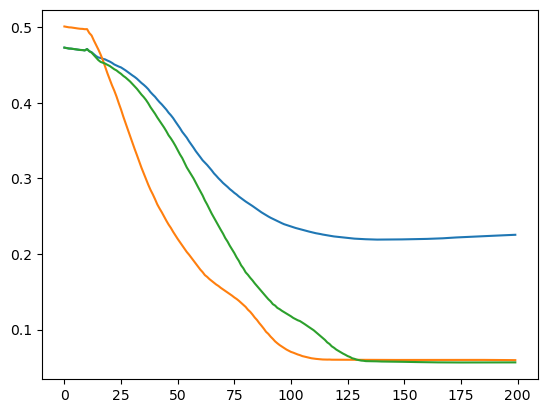

In [75]:
plt.plot(info_mmgks['relError'])
plt.plot(info_GS['relError'])
plt.plot(info_mmgks_dyn['relError'])

<Figure size 640x480 with 0 Axes>

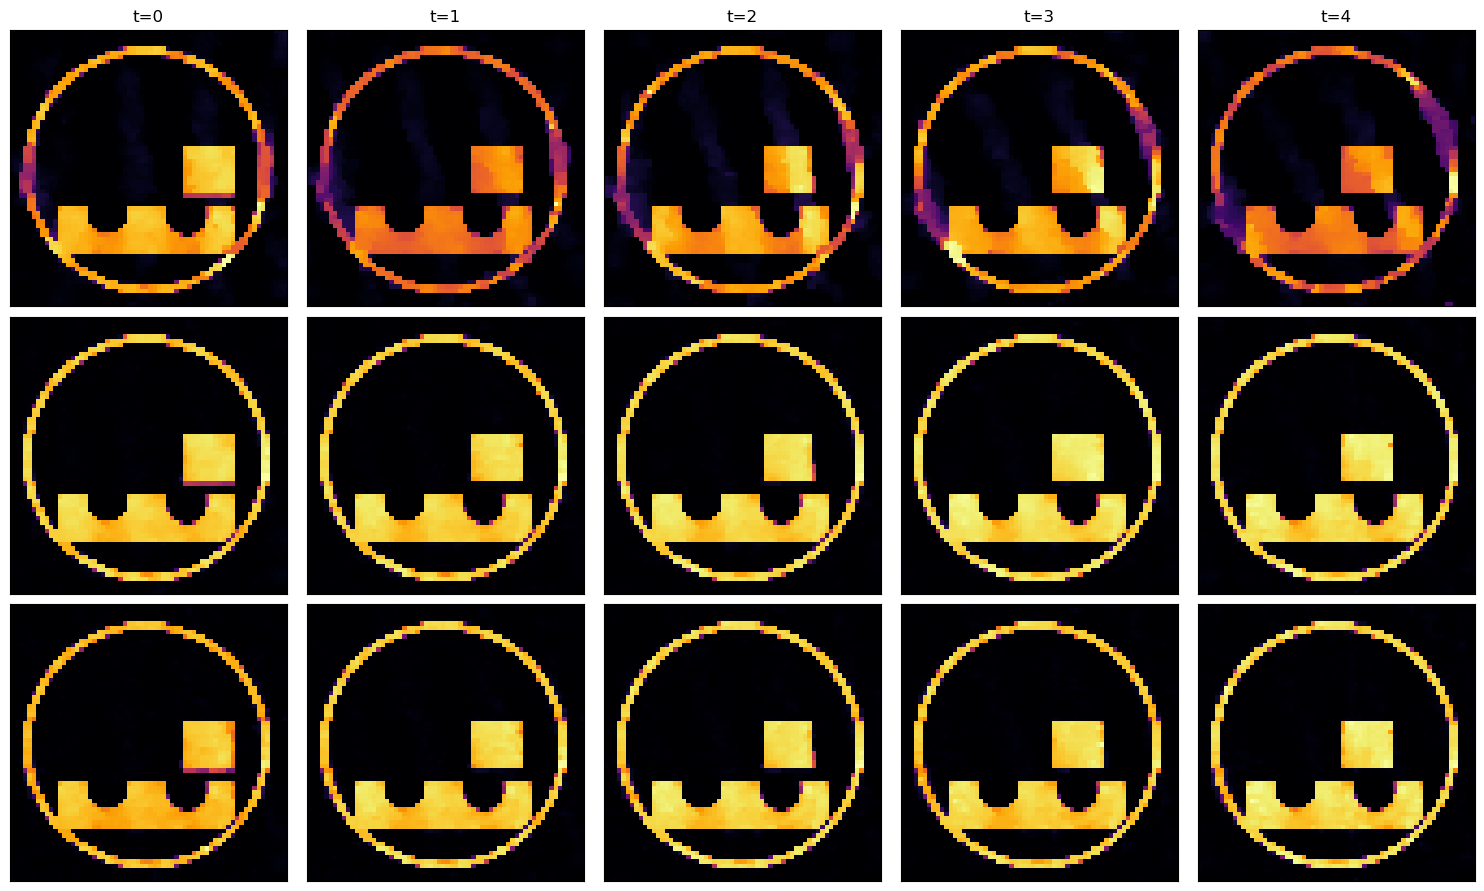

In [81]:
plt.set_cmap('inferno')
fig,ax=plt.subplots(3,t_end,figsize=(15,9),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_list[i].reshape(shape))
    ax[2,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[1,i].imshow(X_GS_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[2,i].set_xticks([])
    ax[2,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
plt.subplots_adjust(wspace=None, hspace=None)
fig.tight_layout(h_pad=1)
# fig.suptitle('Recovered Solutions to the Regularized Problem '  + '(Top Row: Recovered with MMGKS;' + 
#                 ' Middle Row: Recovered with TV-ISO;'   + 
#              ' Bottom Row: Recovered with Dynamic MMGKS)' + '\n' );

In [79]:
folder = 'example_2/views_11'
np.save(f'{folder}/X_mmgks.npy',X_mmgks)
np.save(f'{folder}/X_mmgks_dyn.npy',X_mmgks_dyn)
np.save(f'{folder}/X_GS.npy',X_GS)
np.save(f'{folder}/relError_mmgks.npy',info_mmgks['relError'])
np.save(f'{folder}/relError_mmgks_dyn.npy',info_mmgks_dyn['relError'])
np.save(f'{folder}/relError_GS.npy',info_GS['relError'])
np.save(f'{folder}/regParam_mmgks.npy',info_mmgks['regParam_history'])
np.save(f'{folder}/regParam_mmgks_dyn.npy',info_mmgks_dyn['regParam_history'])
np.save(f'{folder}/regParam_GS.npy',info_GS['regParam_history'])

## Views 11: Grid size:2

In [82]:
v_max = 2

# ## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2,qnorm_opt=2,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']
X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 200/200 [04:40<00:00,  1.40s/it]

Dynamic MMGKS Solution relative error: 0.05212748401834244


In [85]:
print('RRE_MMGKS_DYN',rre_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('SSIM_MMGKS_DYN',ssim_all(X_mmgks_dyn,X_true,nt,nx,ny))

RRE_MMGKS_DYN 0.051983483980372294
SSIM_MMGKS_DYN 0.9981803364168659


In [86]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
print('RRE_optical_flow_rec',rre_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))
print('SSIM_optical_flow_rec',ssim_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))

RRE_optical_flow_rec 0.15924954498041516
SSIM_optical_flow_rec 0.9828502750881765


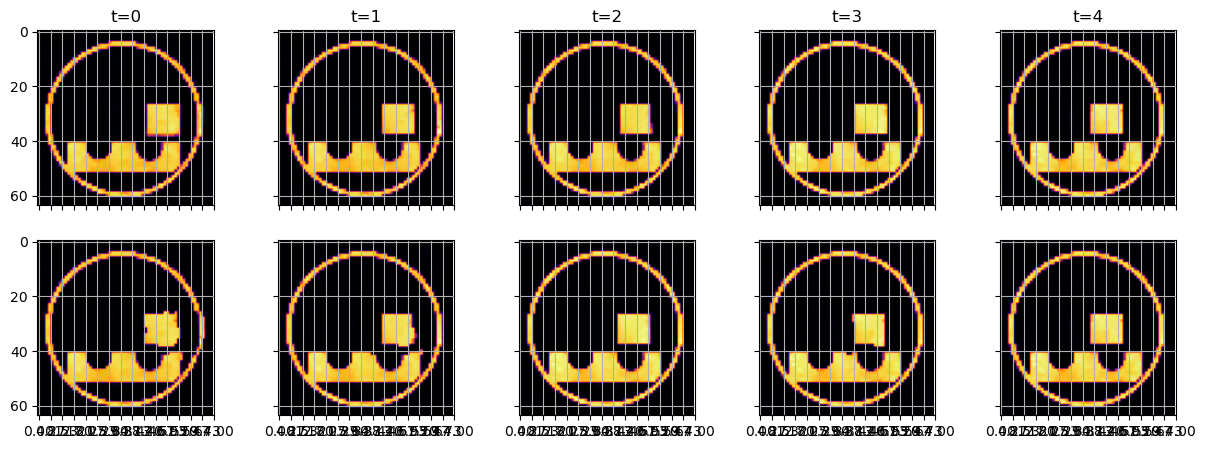

In [89]:
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
fig,ax=plt.subplots(2,t_end,figsize=(15,5),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[1,i].imshow(rec_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    major_ticks = np.linspace(0, nx,16)
    minor_ticks = np.linspace(0, nx,16)

    ax[0,i].set_xticks(minor_ticks,minor=True)
    ax[1,i].set_xticks(minor_ticks, minor=True)
    ax[0,i].set_xticks(major_ticks)
    ax[1,i].set_xticks(major_ticks)

plt.subplots_adjust(wspace=None, hspace=None)
# fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
#              'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

In [90]:
folder = 'example_2/gs_2'

np.save(f'{folder}/X_mmgks_dyn.npy',X_mmgks_dyn)
np.save(f'{folder}/relError_mmgks_dyn.npy',info_mmgks_dyn['relError'])
np.save(f'{folder}/regParam_mmgks_dyn.npy',info_mmgks_dyn['regParam_history'])

## Views 11: Grid size:4

In [91]:
v_max = 4

# ## DYNAMIC MMGKS

(X_mmgks_dyn, info_mmgks_dyn, vs_est, v_primes_est) = MMGKS_dyn_joint_(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = 'dp', regparam_dyn = 'gcv',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta, pnorm_opt=2,qnorm_opt=2,non_neg=non_neg,interval=50)

error_mmgks_dyn = info_mmgks_dyn['relError'][-1]
Ms = info_mmgks_dyn['Ms']
X_mmgks_dyn[X_mmgks_dyn<0]=0
X_mmgks_dyn_list = [X_mmgks_dyn[size*i:size*(i+1)] for i in range(t_end)]

print('Dynamic MMGKS Solution relative error:', error_mmgks_dyn)


running MMGKS...: 100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


Dynamic MMGKS Solution relative error: 0.11004740155602964


In [92]:
print('RRE_MMGKS_DYN',rre_all(X_mmgks_dyn,X_true,nt,nx,ny))
print('SSIM_MMGKS_DYN',ssim_all(X_mmgks_dyn,X_true,nt,nx,ny))

RRE_MMGKS_DYN 0.1071167294412412
SSIM_MMGKS_DYN 0.992131236390817


In [93]:
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
print('RRE_optical_flow_rec',rre_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))
print('SSIM_optical_flow_rec',ssim_all(rec_list[:nt-1],X_mmgks_dyn.reshape(nt,nx,ny)[:nt-1],nt-1,nx,ny))

RRE_optical_flow_rec 0.2184799413962597
SSIM_optical_flow_rec 0.9694817897049643


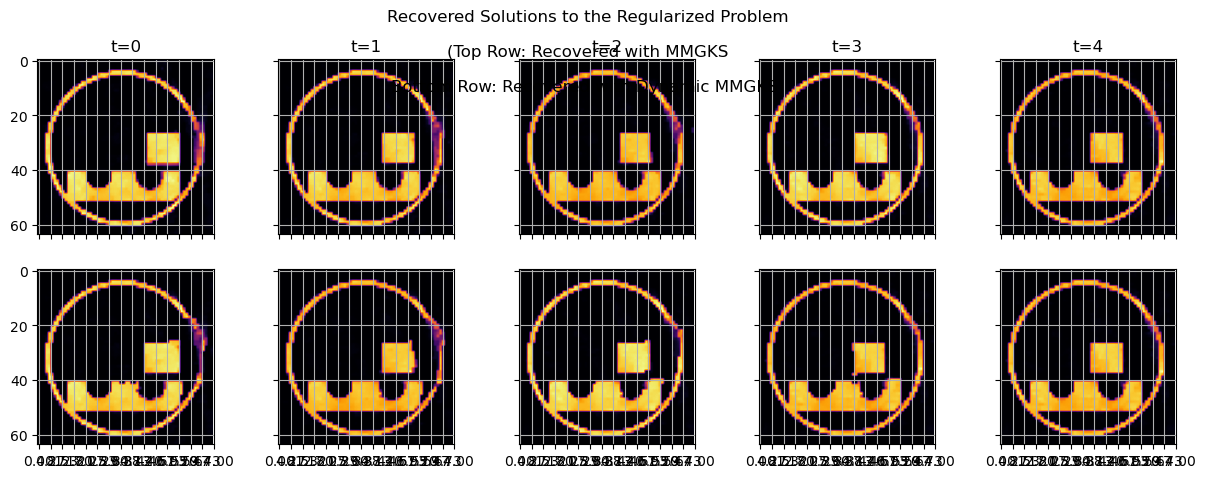

In [96]:
# rec_list = [X_mmgks_dyn_list[-1]]
# for i in range(t_end-1):
#     M = Ms[::-1][i]
#     next_ = M@rec_list[-1]
#     rec_list.append(next_)
rec_list = [X_mmgks_dyn_list[-1]]
for i in range(t_end-1):
    M = Ms[::-1][i]
    next_ = M@X_mmgks_dyn_list[::-1][i] #[-1]
    rec_list.append(next_)
rec_list.reverse()
fig,ax=plt.subplots(2,t_end,figsize=(15,5),sharex=True, sharey=True)

for i in range(0,t_end):
    ax[0,i].imshow(X_mmgks_dyn_list[i].reshape(shape))
    ax[1,i].imshow(rec_list[i].reshape(shape))
    ax[0,i].set_title(f't={i}')
    ax[0,i].grid('minor')
    ax[1,i].grid('minor')
    major_ticks = np.linspace(0, nx,16)
    minor_ticks = np.linspace(0, nx,16)

    ax[0,i].set_xticks(minor_ticks,minor=True)
    ax[1,i].set_xticks(minor_ticks, minor=True)
    ax[0,i].set_xticks(major_ticks)
    ax[1,i].set_xticks(major_ticks)

plt.subplots_adjust(wspace=None, hspace=None)
fig.suptitle('Recovered Solutions to the Regularized Problem' + '\n' + '\n' + '(Top Row: Recovered with MMGKS' + '\n'+ '\n'  + 
             'Bottom Row: Recovered with Dynamic MMGKS)' + '\n' + ' ' );

In [97]:
folder = 'example_2/gs_4'

np.save(f'{folder}/X_mmgks_dyn.npy',X_mmgks_dyn)
np.save(f'{folder}/relError_mmgks_dyn.npy',info_mmgks_dyn['relError'])
np.save(f'{folder}/regParam_mmgks_dyn.npy',info_mmgks_dyn['regParam_history'])